In [5]:
import sys, os

!{sys.executable} -m pip install -q pyvista planetary-computer pystac-client pystac stackstac

In [6]:
# display PyGMTSAR version
from pygmtsar import __version__
__version__

'2024.8.30.post3'

In [7]:
# specify GMTSAR installation path
PATH = os.environ['PATH']
if PATH.find('GMTSAR') == -1:
    PATH = os.environ['PATH'] + ':/usr/local/GMTSAR/bin/'
    %env PATH {PATH}

### Flood Detection

This is a jupyter notebook copied form the Flood (Correlation) Map example from https://github.com/AlexeyPechnikov/pygmtsar.

In [8]:
import xarray as xr
import numpy as np

import pandas as pd
import geopandas as gpd
import json

from dask.distributed import Client
import dask

In [9]:
# plotting modules
import pyvista as pv
# magic trick for white background
pv.set_plot_theme("document")
import panel
panel.extension(comms='ipywidgets')
panel.extension('vtk')
from contextlib import contextmanager
import matplotlib.pyplot as plt
@contextmanager
def mpl_settings(settings):
    original_settings = {k: plt.rcParams[k] for k in settings}
    plt.rcParams.update(settings)
    yield
    plt.rcParams.update(original_settings)
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
%matplotlib inline

In [10]:
# define Pandas display settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

In [11]:
from pygmtsar import S1, Stack, tqdm_dask, ASF, Tiles, XYZTiles

In [12]:
SUBSWATH = 2
POLARIZATION = 'VV'
DATE = 2018

In [13]:
def get_sar_1_collections_from(file_path):
    with open (file_path, 'r') as f:
        scenes = f.readlines()
    return [f.strip() for f in scenes]

In [14]:
# SAR_1_COLLECTIONS_FILE = 'data/bursts/Oct 2020 - Nov 2020 Ascending.txt'
FILENAME = 'Aug 2018 - Sep 2018'
SAR_1_COLLECTIONS_FILE = f'data/bursts/{FILENAME}.txt'
scenes = get_sar_1_collections_from(SAR_1_COLLECTIONS_FILE)

In [15]:
scenes

['S1_067577_IW2_20180928T214659_VH_DEC8-BURST',
 'S1_067577_IW2_20180928T214659_VV_DEC8-BURST',
 'S1_067576_IW2_20180928T214657_VH_DEC8-BURST',
 'S1_067576_IW2_20180928T214657_VV_DEC8-BURST',
 'S1_067575_IW2_20180928T214654_VH_DEC8-BURST',
 'S1_067575_IW2_20180928T214654_VV_DEC8-BURST',
 'S1_067577_IW2_20180922T214617_VH_89E5-BURST',
 'S1_067577_IW2_20180922T214617_VV_89E5-BURST',
 'S1_067576_IW2_20180922T214615_VH_89E5-BURST',
 'S1_067576_IW2_20180922T214615_VV_89E5-BURST',
 'S1_067575_IW2_20180922T214612_VH_8297-BURST',
 'S1_067575_IW2_20180922T214612_VV_8297-BURST',
 'S1_067577_IW2_20180916T214659_VH_8274-BURST',
 'S1_067577_IW2_20180916T214659_VV_8274-BURST',
 'S1_067576_IW2_20180916T214656_VH_8274-BURST',
 'S1_067576_IW2_20180916T214656_VV_8274-BURST',
 'S1_067575_IW2_20180916T214654_VH_8274-BURST',
 'S1_067575_IW2_20180916T214654_VV_8274-BURST',
 'S1_067577_IW2_20180904T214659_VH_FDC9-BURST',
 'S1_067577_IW2_20180904T214659_VV_FDC9-BURST',
 'S1_067576_IW2_20180904T214656_VH_FDC9-

In [16]:
SCENES = scenes

In [17]:
SCENES.reverse()

In [18]:
WORKDIR = 'raw_golden_desc'
DATADIR = 'data_golden_desc'
!rm -r {WORKDIR}/*
!rm -r {DATADIR}/*

rm: cannot remove 'raw_golden_desc/*': No such file or directory


In [19]:
# define DEM and landmask filenames inside data directory
DEM = f'{DATADIR}/dem.nc'

In [20]:
geojson = '''
{
  "type": "Feature",
  "geometry": {
    "type": "Point",
    "coordinates": [121.0017, 14.5361]
  },
  "properties": {}
}
'''
AOI = gpd.GeoDataFrame.from_features([json.loads(geojson)])
AOI = AOI.buffer(0.02)
AOI

0    POLYGON ((121.0217 14.5361, 121.0216 14.53414, 121.02132 14.5322, 121.02084 14.53029, 121.02018 ...
dtype: geometry

In [21]:
# Set these variables to None and you will be prompted to enter your username and password below.
asf_username = 'mirasnickanthony'
asf_password = 'e44 4E6 E447E S56E!'

In [22]:
# Set these variables to None and you will be prompted to enter your username and password below.
asf = ASF(asf_username, asf_password)
# Optimized scene downloading from ASF - only the required subswaths and polarizations.
print(asf.download(DATADIR, SCENES))

ASF Downloading Bursts Catalog:   0%|          | 0/1 [00:00<?, ?it/s]

ASF Downloading Sentinel-1 Bursts:   0%|          | 0/36 [00:00<?, ?it/s]

ERROR: download attempt 1 failed for {
  "geometry": {
    "coordinates": [
      [
        [
          121.330072,
          14.21612
        ],
        [
          121.367222,
          14.400397
        ],
        [
          120.943933,
          14.48356
        ],
        [
          120.544148,
          14.561471
        ],
        [
          120.506034,
          14.369058
        ],
        [
          120.906302,
          14.295215
        ],
        [
          121.330072,
          14.21612
        ]
      ]
    ],
    "type": "Polygon"
  },
  "properties": {
    "additionalUrls": [
      "https://sentinel1-burst.asf.alaska.edu/S1B_IW_SLC__1SDV_20180922T214615_20180922T214642_012833_017B1E_89E5/IW2/VH/1.xml"
    ],
    "beamModeType": "IW",
    "browse": null,
    "burst": {
      "absoluteBurstID": 27563202,
      "azimuthAnxTime": "2733.5372191109",
      "azimuthTime": "2018-09-22T21:46:17.859112",
      "burstIndex": 1,
      "fullBurstID": "032_067577_IW2",
      "r

In [23]:
# scan the data directory for SLC scenes and download missed orbits
S1.download_orbits(DATADIR, S1.scan_slc(DATADIR))

NOTE: Found multiple scenes for a single day, use function Stack.reframe() to stitch the scenes


0    S1A_OPER_AUX_POEORB_OPOD_20210308T174208_V20180810T225942_20180812T005942.EOF.zip
1    S1A_OPER_AUX_POEORB_OPOD_20210308T213558_V20180822T225942_20180824T005942.EOF.zip
2    S1A_OPER_AUX_POEORB_OPOD_20210309T012641_V20180903T225942_20180905T005942.EOF.zip
3    S1A_OPER_AUX_POEORB_OPOD_20210309T051513_V20180915T225942_20180917T005942.EOF.zip
4    S1B_OPER_AUX_POEORB_OPOD_20210314T173547_V20180921T225942_20180923T005942.EOF.zip
5    S1A_OPER_AUX_POEORB_OPOD_20210309T090551_V20180927T225942_20180929T005942.EOF.zip
Name: orbit, dtype: object

Tiles Parallel Downloading:   0%|          | 0/2 [00:00<?, ?it/s]

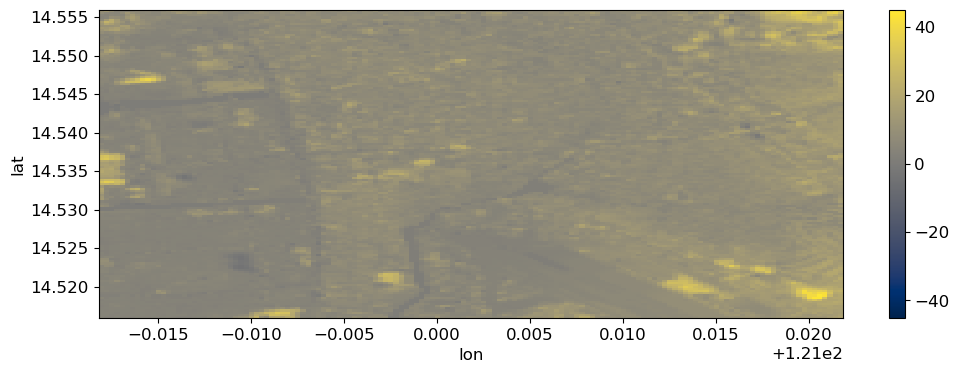

In [24]:
# download Copernicus Global DEM 1 arc-second
Tiles().download_dem(AOI, filename=DEM, skip_exist=False).plot.imshow(cmap='cividis')

In [25]:
%%capture
# simple Dask initialization
if 'client' in globals():
    client.close()
client = Client();

2024-11-09 14:20:52,265 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('getitem-cbd24cdf0d885a83d1bd5ca1c971895a', 9, 0, 0) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: waiting
old run_spec: (<function getitem at 0x7f465d8e4220>, (('where-39852153c8cd7de53724fcebc57ca86c', 4, 0, 0), (array([0]), slice(None, None, None), slice(None, None, None))), {})
new run_spec: (<function execute_task at 0x7f468417af20>, (('where-getitem-cbd24cdf0d885a83d1bd5ca1c971895a', 9, 0, 0),), {})
old token: ('tuple', [('3a54a0fe35af534a', []), ('tuple', [('tuple', ['where-39852153c8cd7de53724fcebc57ca86c', 4, 0, 0]), ('tuple', [('942c203a

### Select Original Scenes and Orbits

In [26]:
scenes = S1.scan_slc(DATADIR, subswath=SUBSWATH, polarization=POLARIZATION)

NOTE: Found multiple scenes for a single day, use function Stack.reframe() to stitch the scenes


In [27]:
sbas = Stack(WORKDIR, drop_if_exists=True).set_scenes(scenes)

NOTE: auto set reference scene 2018-08-11. You can change it like Stack.set_reference("2022-01-20")


### Reframe Scene

"Stitch sequential scenes and crop the subswath to a smaller area for faster processing when the full area is not needed."

In [28]:
sbas.compute_reframe(AOI)

Reframing:   0%|          | 0/6 [00:00<?, ?it/s]

### Load DEM

In [29]:
# define the area of interest (AOI) to speedup the processing
sbas.load_dem(DEM, AOI)

Save DEM on WGS84 Ellipsoid:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

In [30]:
sbas.compute_align()

Aligning Reference:   0%|          | 0/1 [00:00<?, ?it/s]

Aligning Repeat:   0%|          | 0/5 [00:00<?, ?it/s]

Convert Subswath:   0%|          | 0/6 [00:00<?, ?it/s]

In [31]:
sbas.compute_geocode(1)

Radar Transform Computing:   0%|          | 0/1 [00:00<?, ?it/s]

Radar Transform Saving:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Radar Transform Indexing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Radar Inverse Transform Computing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Satellite Look Vector Computing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

### Persistent Scatterers Function (PSF)

In [32]:
sbas.compute_ps()

Intensity Normalization:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Compute Stability Measures:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

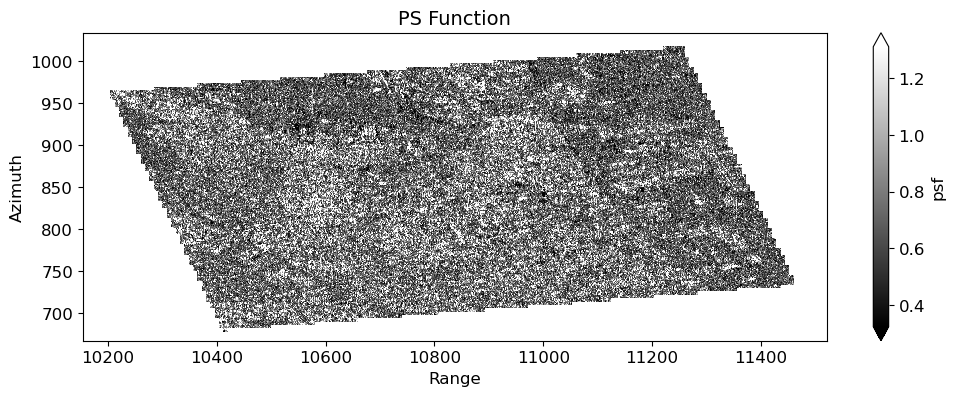

In [33]:
sbas.plot_psfunction(quantile=[0.01, 0.90])

### Baseline Pairs

In [34]:
baseline_pairs = sbas.sbas_pairs(days=24)
baseline_pairs

ref        rep  ref_baseline  rep_baseline                   pair  \
0 2018-08-11 2018-08-23         -0.00        -30.74  2018-08-11 2018-08-23   
1 2018-08-11 2018-09-04         -0.00         60.60  2018-08-11 2018-09-04   
2 2018-08-23 2018-09-04        -30.74         60.60  2018-08-23 2018-09-04   
3 2018-08-23 2018-09-16        -30.74         17.87  2018-08-23 2018-09-16   
4 2018-09-04 2018-09-16         60.60         17.87  2018-09-04 2018-09-16   
5 2018-09-04 2018-09-22         60.60         -8.81  2018-09-04 2018-09-22   
6 2018-09-04 2018-09-28         60.60          9.48  2018-09-04 2018-09-28   
7 2018-09-16 2018-09-22         17.87         -8.81  2018-09-16 2018-09-22   
8 2018-09-16 2018-09-28         17.87          9.48  2018-09-16 2018-09-28   
9 2018-09-22 2018-09-28         -8.81          9.48  2018-09-22 2018-09-28   

   baseline  duration rel  
0    -30.74        12 NaT  
1     60.60        24 NaT  
2     91.34        12 NaT  
3     48.61        24 NaT  
4    -42.73        12 NaT  
5    -69.41        18 NaT  
6    -51.12        24 NaT  
7    -26.68         6 NaT  
8     -8.39        12 NaT  
9     18.29         6 NaT

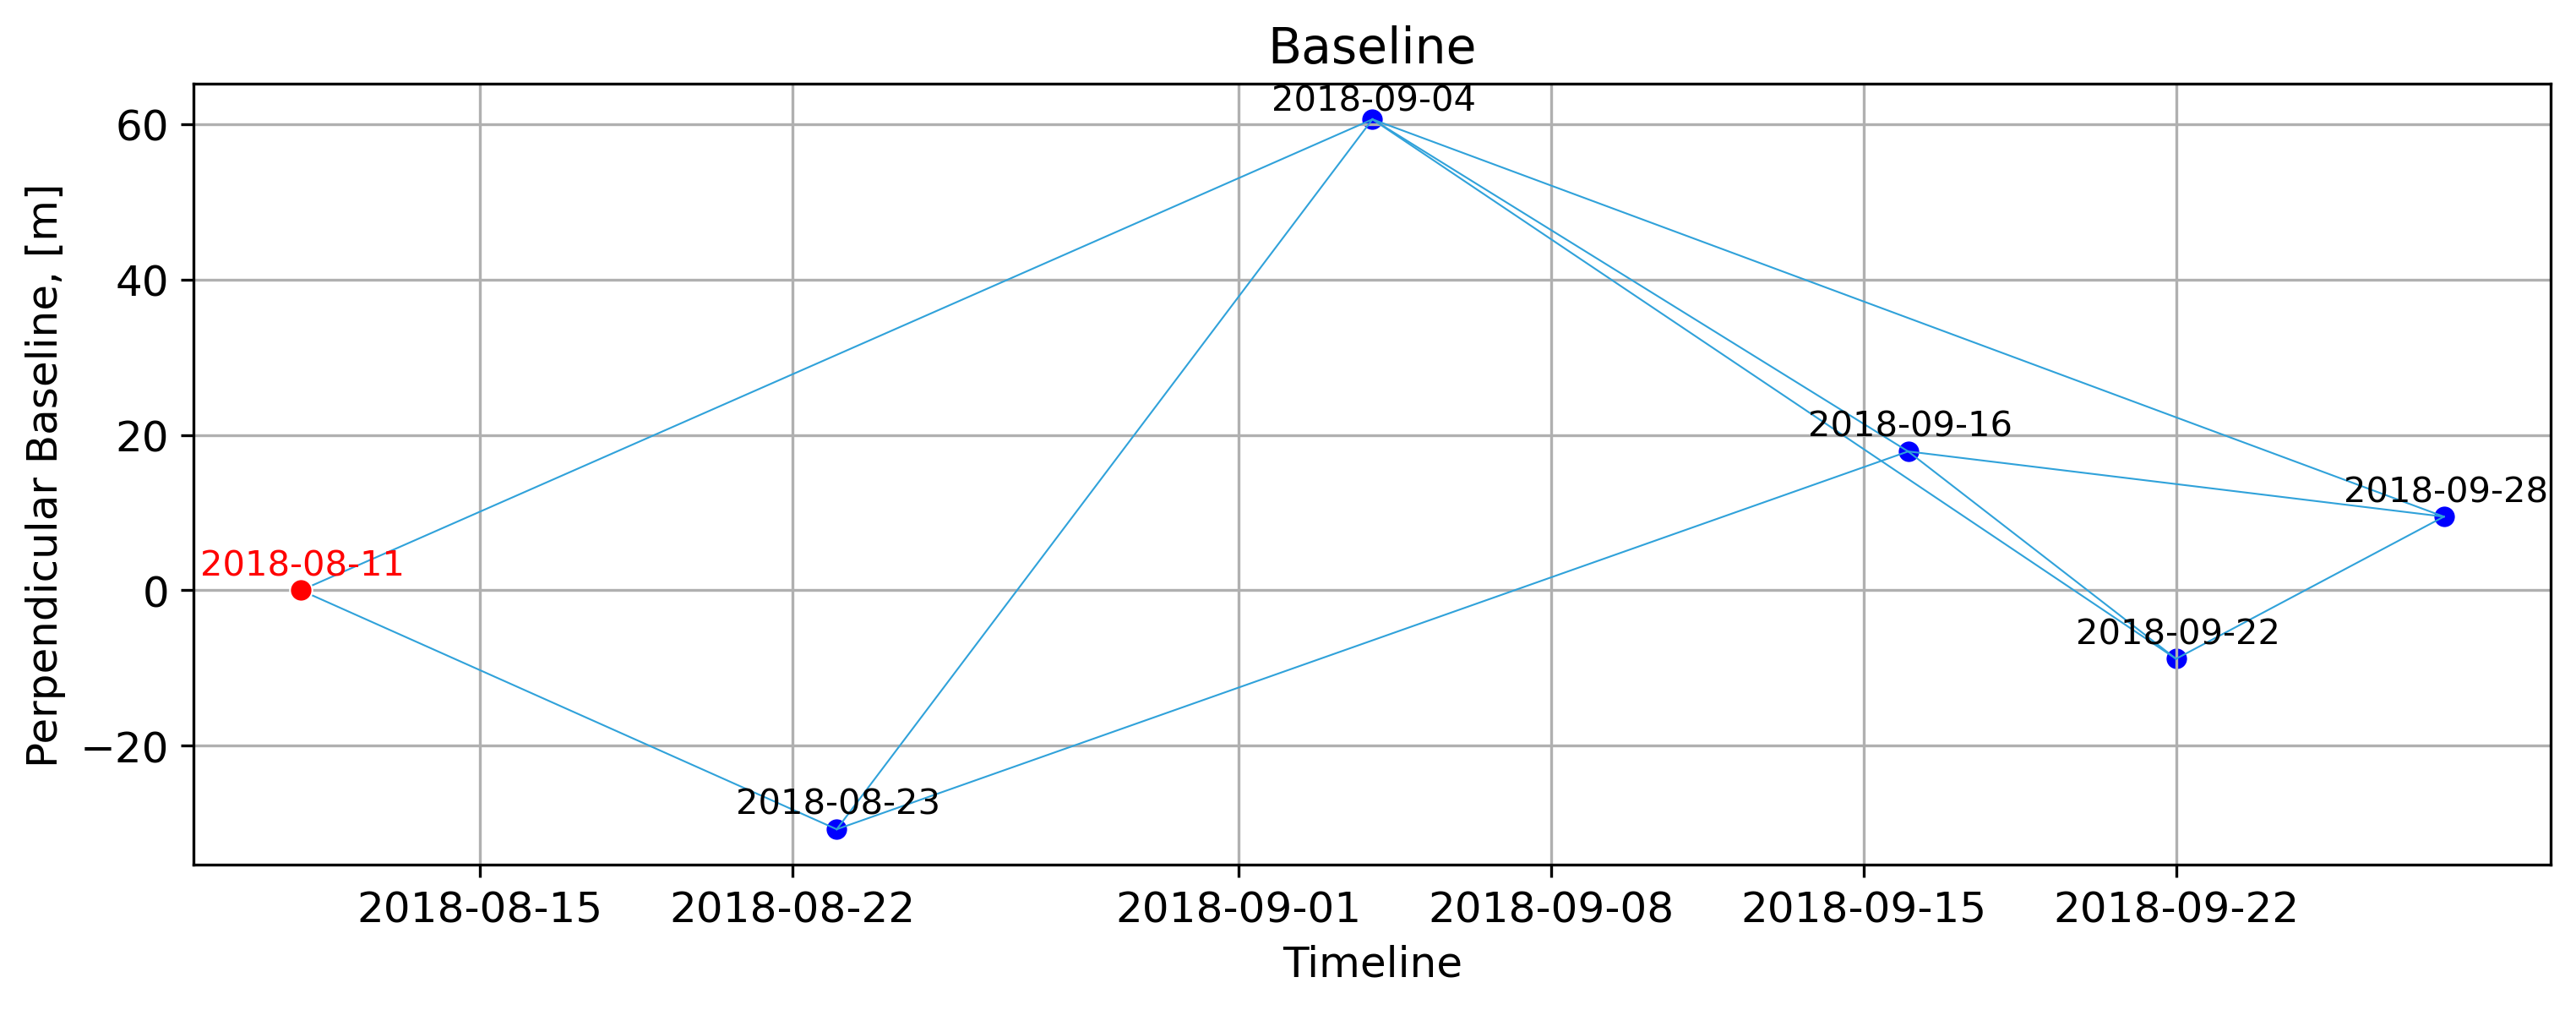

In [35]:
with mpl_settings({'figure.dpi': 300}):
    sbas.plot_baseline(baseline_pairs)

### Global Surface Water Mask

<xarray.DataArray 'landmask' (lat: 144, lon: 144)> Size: 21kB
dask.array<gt, shape=(144, 144), dtype=bool, chunksize=(144, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 1kB 14.52 14.52 14.52 14.52 ... 14.56 14.56 14.56
  * lon      (lon) float64 1kB 121.0 121.0 121.0 121.0 ... 121.0 121.0 121.0

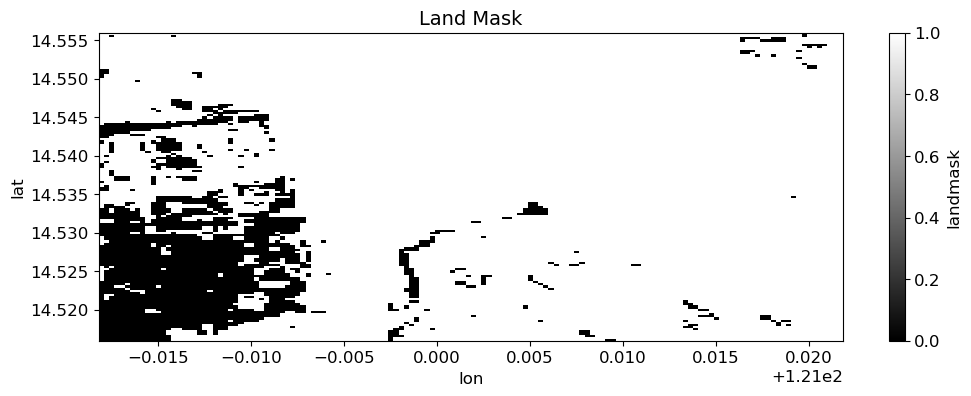

In [40]:
sbas.set_landmask(None)
sbas.load_landmask('recurrence_120E_20Nv1_4_2021.tif')
landmask = (sbas.get_landmask()*-1)>-0.02
sbas.set_landmask(None)
sbas.plot_landmask(landmask)
landmask

In [41]:
landmask_ra = sbas.ll2ra(landmask)
landmask_ra

<xarray.DataArray 'landmask' (y: 183, x: 171)> Size: 125kB
dask.array<from-value, shape=(183, 171), dtype=float32, chunksize=(183, 171), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 1kB 668.5 670.5 672.5 ... 1.028e+03 1.03e+03 1.032e+03
  * x        (x) float64 1kB 1.016e+04 1.017e+04 ... 1.151e+04 1.152e+04

In [42]:
# load radar topography
topo = sbas.get_topo()
# load Sentinel-1 data
data = sbas.open_data()

### Interferograms Specified By M. Chini Et Al.

In [43]:
### ONE SHOT

WAVELENGTH = 20
COARSEN_GRID = (1, 4)
sbas.compute_interferogram_multilook(
    baseline_pairs,
    'intf_mlook',
    wavelength=WAVELENGTH,
    phase=sbas.phasediff(baseline_pairs, data, topo),
    coarsen=COARSEN_GRID
)


ds_sbas = sbas.open_stack('intf_mlook')
ds_sbas = ds_sbas.where(landmask_ra.interp_like(ds_sbas, method='nearest'))
intf_sbas = ds_sbas.phase
corr_sbas = ds_sbas.correlation
sbas_phase_goldstein = sbas.goldstein(intf_sbas, corr_sbas, 8)
intf15m = sbas.interferogram(sbas_phase_goldstein)


tqdm_dask(result := dask.persist(corr_sbas, intf15m), desc='Compute Phase and Correlation')
corr, intf = result
corr_ll = sbas.ra2ll(corr_sbas)


PRE_FLOOD_DOI = '2018-08-23 2018-09-04'
CO_FLOOD_DOI = '2018-09-04 2018-09-16'
corr_sbas_df = corr_ll.to_dataframe()
pre_flood_df = corr_sbas_df[corr_sbas_df.index.get_level_values(0) == PRE_FLOOD_DOI]
co_flood_df = corr_sbas_df[corr_sbas_df.index.get_level_values(0) == CO_FLOOD_DOI]
pre_flood_df.to_csv(f'csv/{PRE_FLOOD_DOI} {POLARIZATION}.csv')
co_flood_df.to_csv(f'csv/{CO_FLOOD_DOI} {POLARIZATION}.csv')
print('Saved Dataframes')

Saving Interferogram 01...10 from 10:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Compute Phase and Correlation:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

In [174]:
WAVELENGTH = 20
COARSEN_GRID = (1, 4)
sbas.compute_interferogram_multilook(
    baseline_pairs,
    'intf_mlook',
    wavelength=WAVELENGTH,
    phase=sbas.phasediff(baseline_pairs, data, topo),
    coarsen=COARSEN_GRID
)

Saving Interferogram 01...10 from 10:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [175]:
ds_sbas = sbas.open_stack('intf_mlook')
ds_sbas = ds_sbas.where(landmask_ra.interp_like(ds_sbas, method='nearest'))
intf_sbas = ds_sbas.phase
corr_sbas = ds_sbas.correlation
sbas_phase_goldstein = sbas.goldstein(intf_sbas, corr_sbas, 8)
intf15m = sbas.interferogram(sbas_phase_goldstein)

In [176]:
tqdm_dask(result := dask.persist(corr_sbas, intf15m), desc='Compute Phase and Correlation')
# unpack results for a single interferogram
corr, intf = result

Compute Phase and Correlation:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

In [177]:
corr_ll = sbas.ra2ll(corr_sbas)

In [178]:
CAPTION = f"Correlation Lost: Indicates Flooding {DATE}"

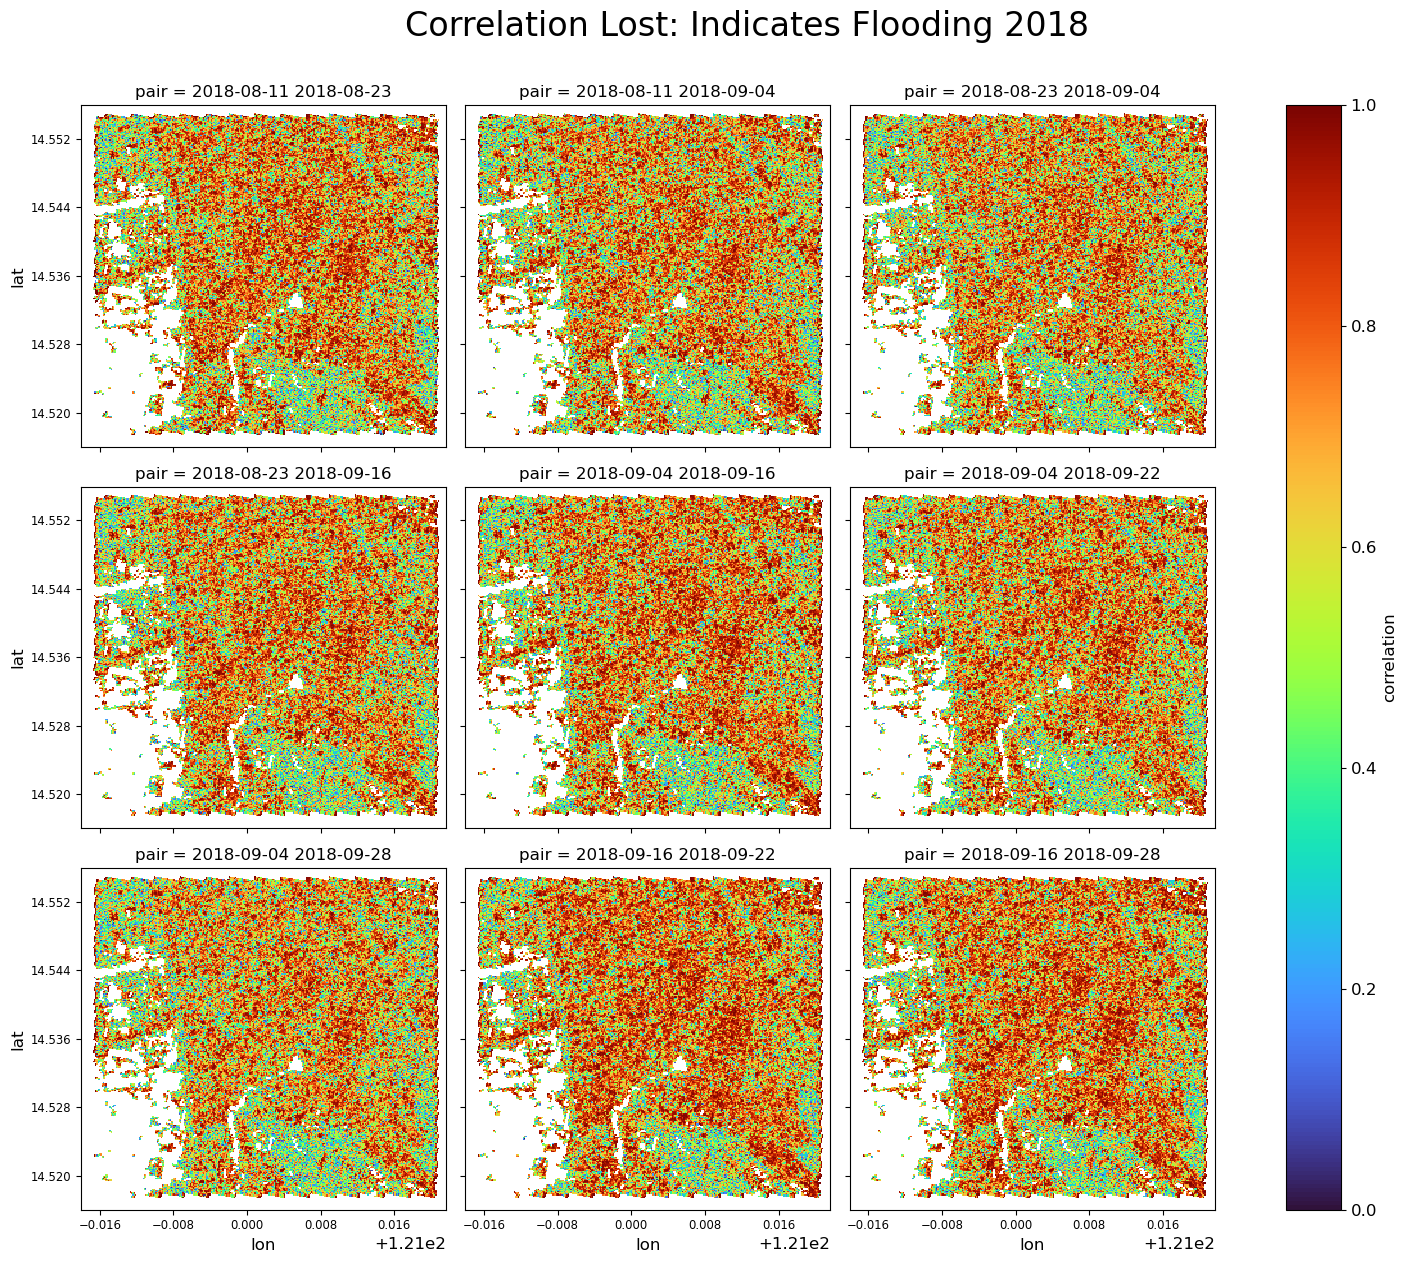

In [179]:
sbas.plot_correlations(corr_ll.where(corr_ll)[:9], cols=3, cmap='turbo', caption=CAPTION)

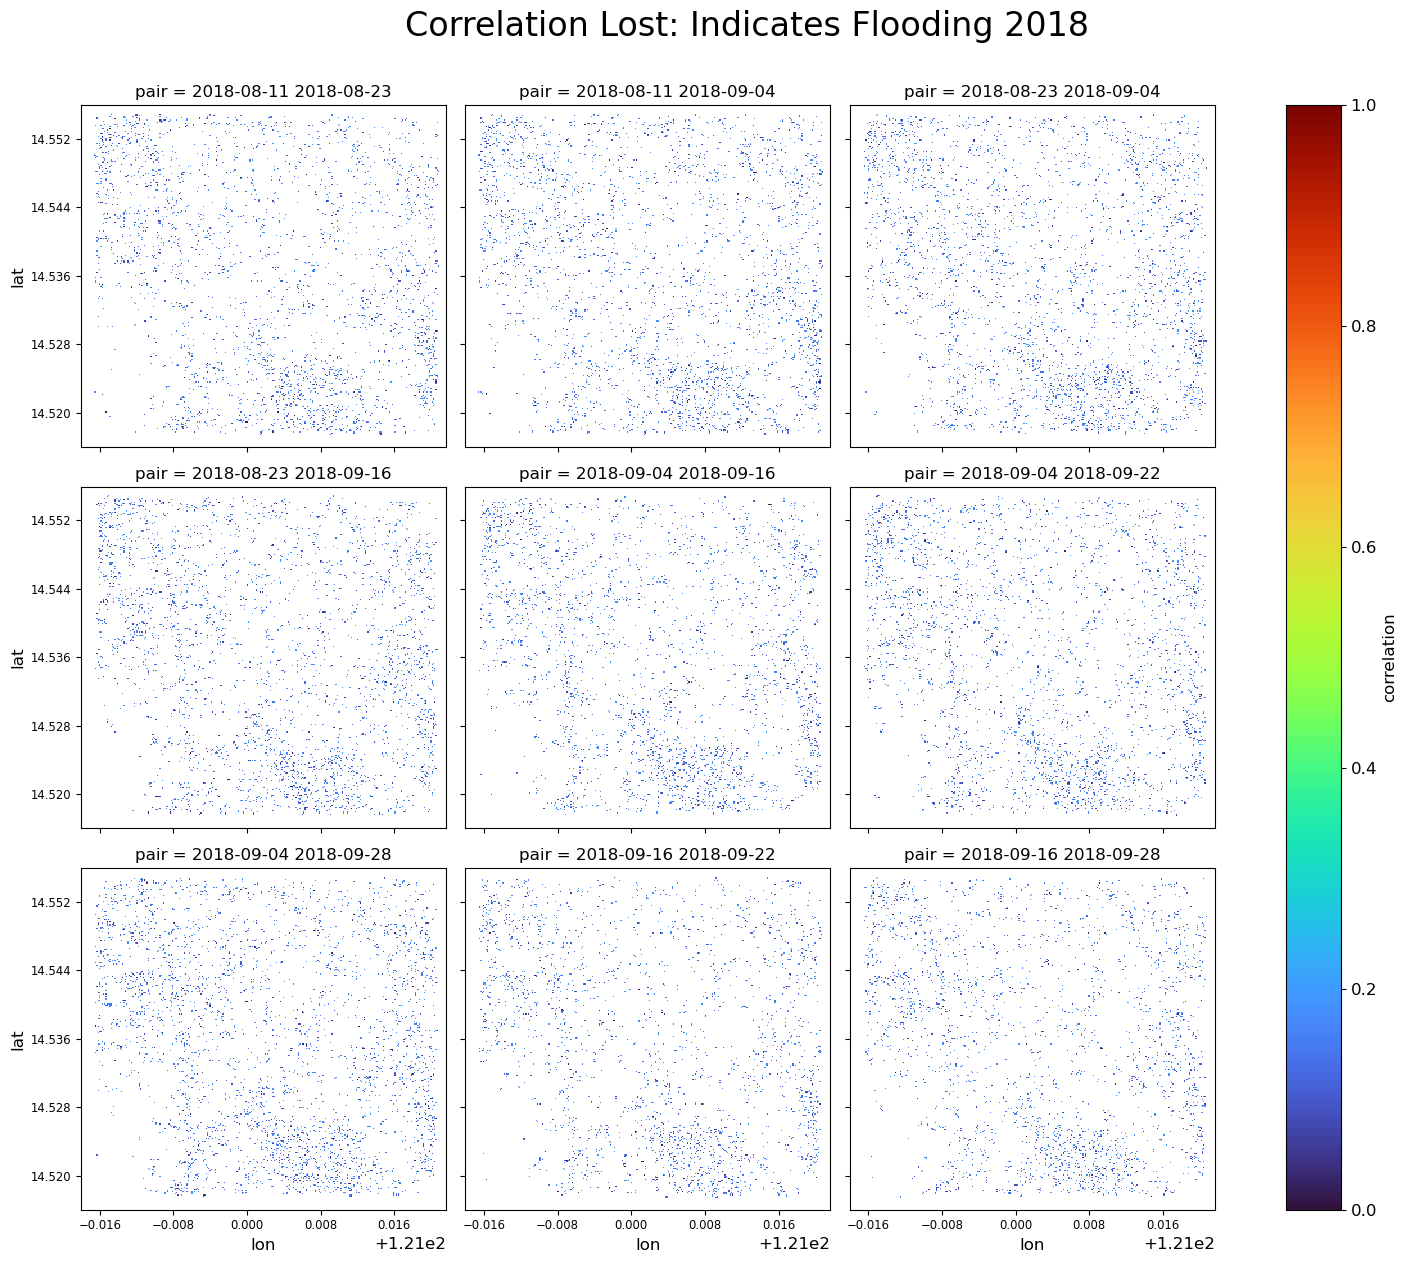

In [180]:
sbas.plot_correlations(corr_ll.where(corr_ll<0.2)[:9], cols=3, cmap='turbo', caption=CAPTION)

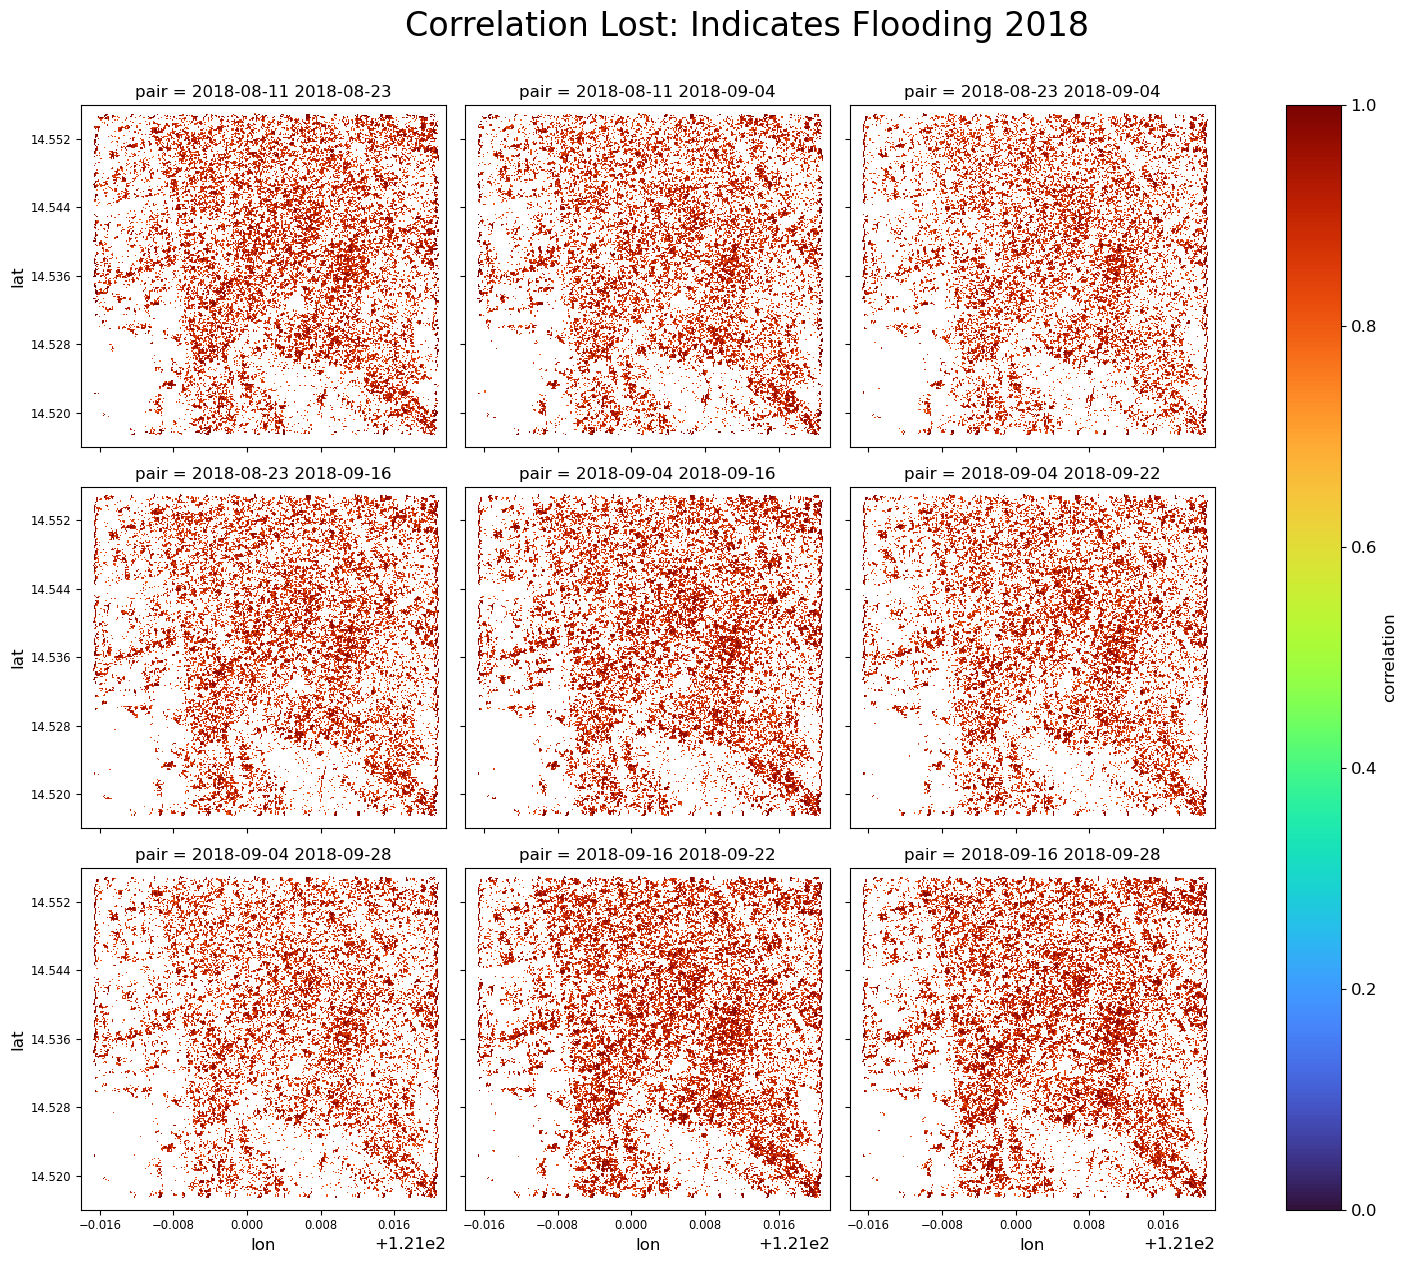

In [181]:
sbas.plot_correlations(corr_ll.where(corr_ll>0.8)[:9], cols=3, cmap='turbo', caption=CAPTION)

In [182]:
disp_sbas = sbas.los_displacement_mm(sbas.lstsq(intf_sbas, corr_sbas))

Note: data chunk size (inf, inf) is too large for stack processing
Note: auto tune data chunk size to a half of NetCDF chunk: (256, 256)


In [183]:
disp_sbas_stl = sbas.stl(disp_sbas)
disp_sbas_stl = sbas.sync_cube(disp_sbas_stl, 'disp_sbas_stl')

Note: data chunk size (inf, inf) is too large for stack processing
Note: auto tune data chunk size to a half of NetCDF chunk: (256, 256)


Syncing NetCDF 2D/3D Dataset:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

In [184]:
disp_sbas_stl_trend_mean = disp_sbas_stl.trend.mean(['y', 'x'])
disp_sbas_stl_seasonal_mean = disp_sbas_stl.seasonal.mean(['y', 'x'])

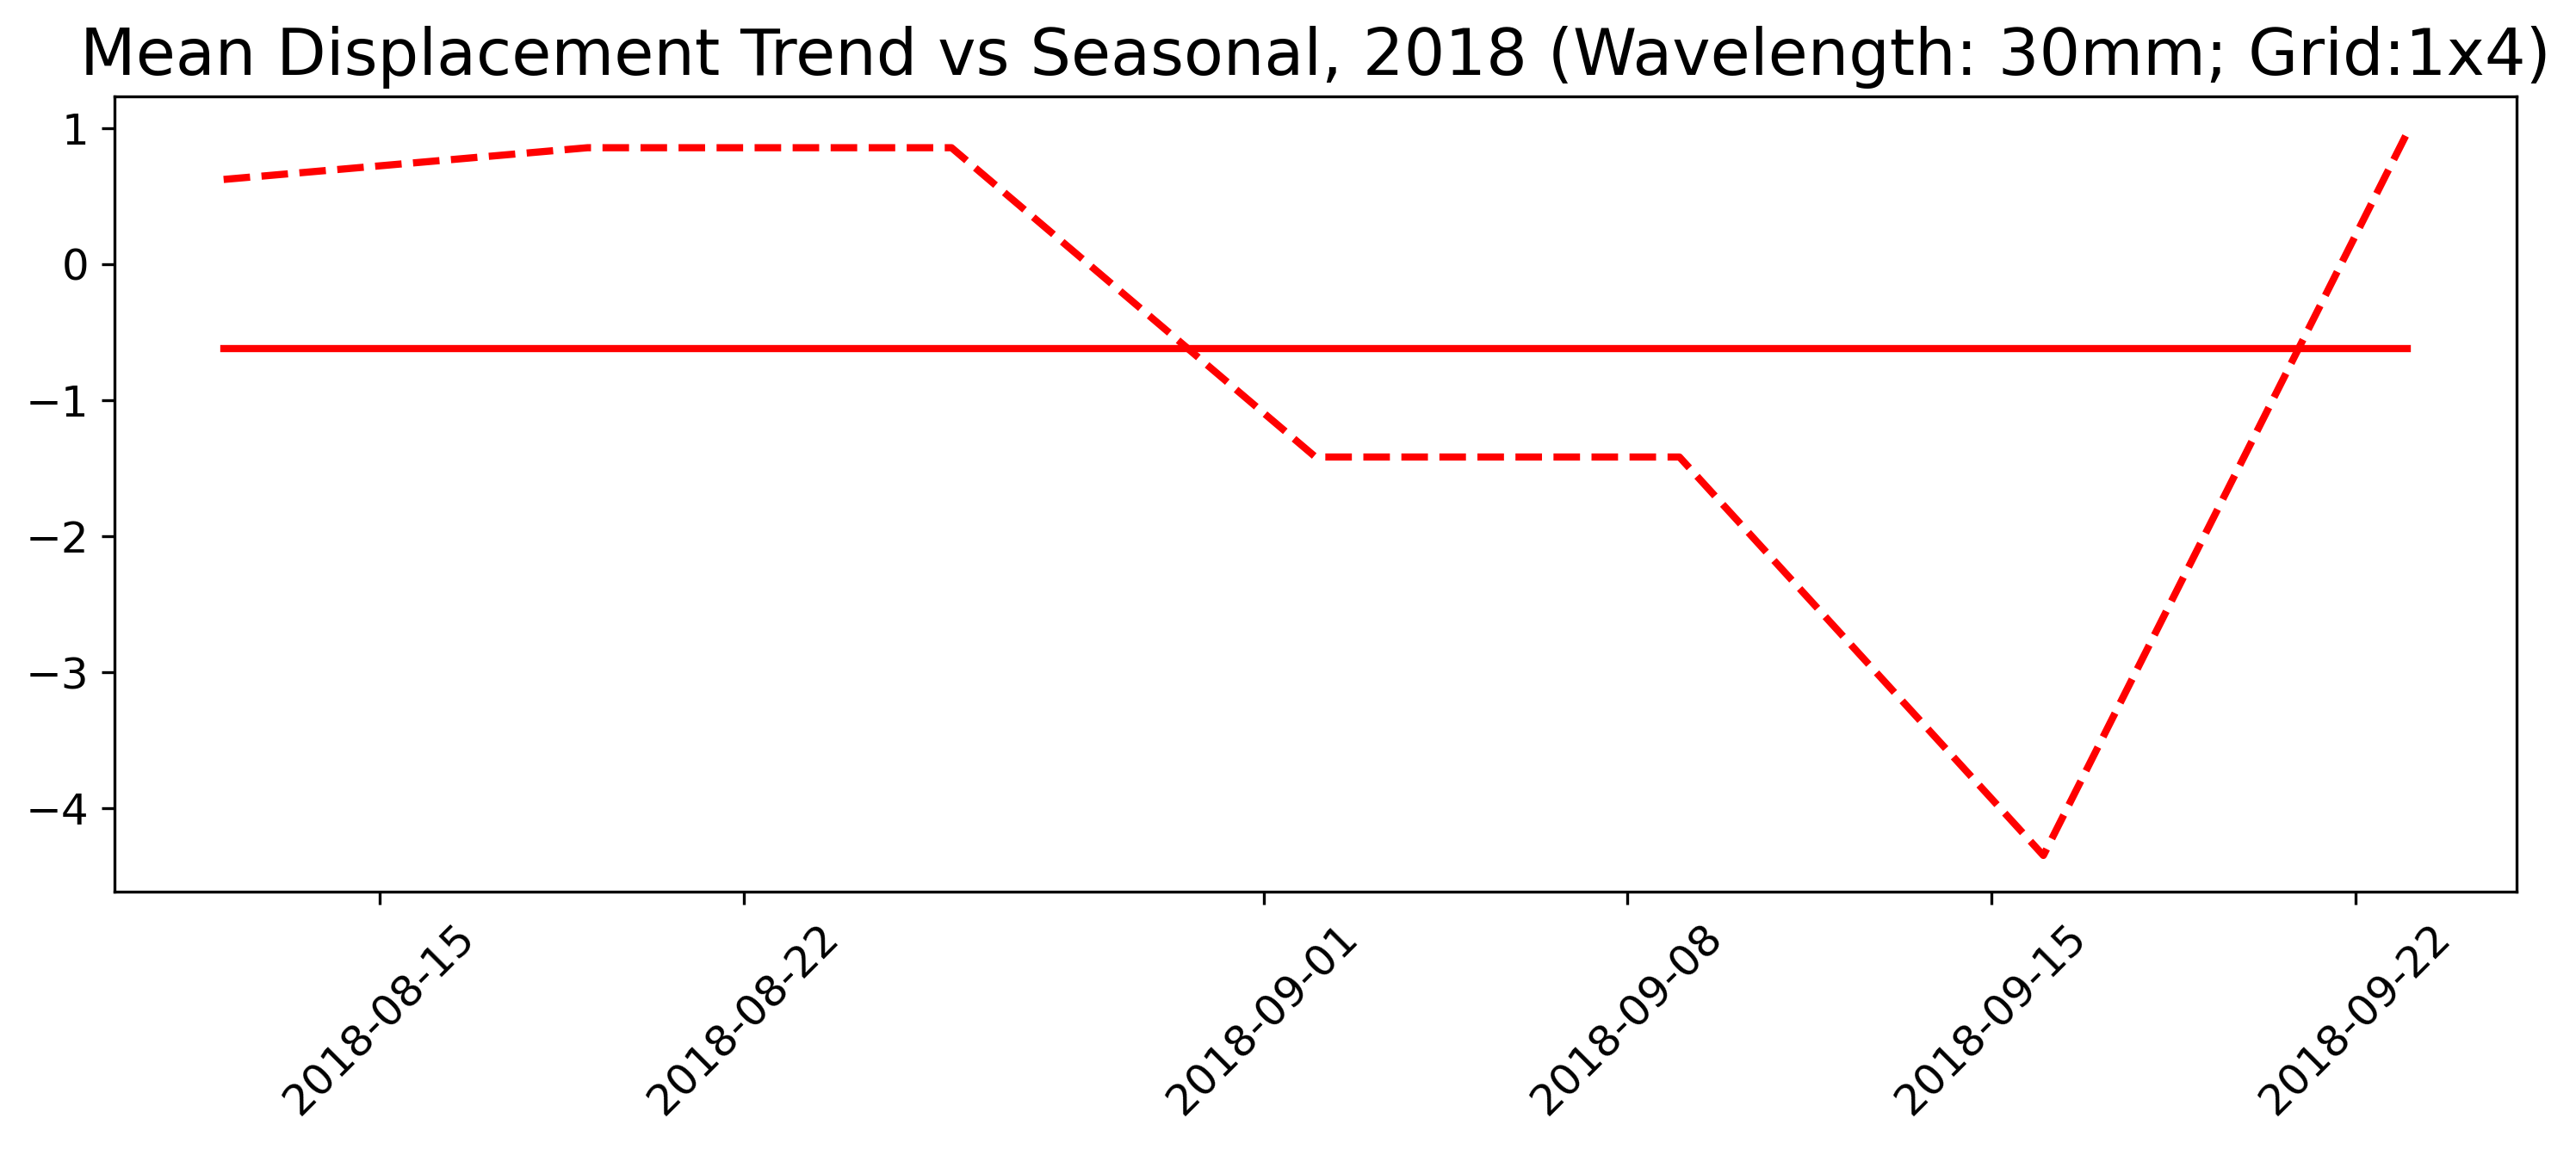

<Figure size 1200x400 with 0 Axes>

In [185]:
title = f'Mean Displacement Trend vs Seasonal, {DATE} (Wavelength: 30mm; Grid:1x4)'
plt.figure(figsize=(12, 4), dpi=300)

plt.plot(disp_sbas_stl_trend_mean.date, disp_sbas_stl_trend_mean, c='r', lw=2, label='Displacement Trend')
plt.plot(disp_sbas_stl_seasonal_mean.date, disp_sbas_stl_seasonal_mean, c='r',  ls='--', lw=2, label='Displacement Seasonal')
plt.title(title, fontsize=18)
plt.xticks(rotation=45)
plt.show()
plt.savefig(title + '.jpg')

In [186]:
corr_sbas_lstsq = sbas.lstsq(corr_sbas)

Note: data chunk size (inf, inf) is too large for stack processing
Note: auto tune data chunk size to a half of NetCDF chunk: (256, 256)


In [187]:
corr_sbas_lstsq = sbas.sync_cube(corr_sbas_lstsq, 'corr_sbas_lstsq')
corr_sbas_lstsq_mean = corr_sbas_lstsq.mean(['y', 'x'])

Syncing NetCDF 2D/3D Dataset:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

In [188]:
corr_sbas_lstsq_stl = sbas.stl(corr_sbas_lstsq)

Note: data chunk size (inf, inf) is too large for stack processing
Note: auto tune data chunk size to a half of NetCDF chunk: (256, 256)


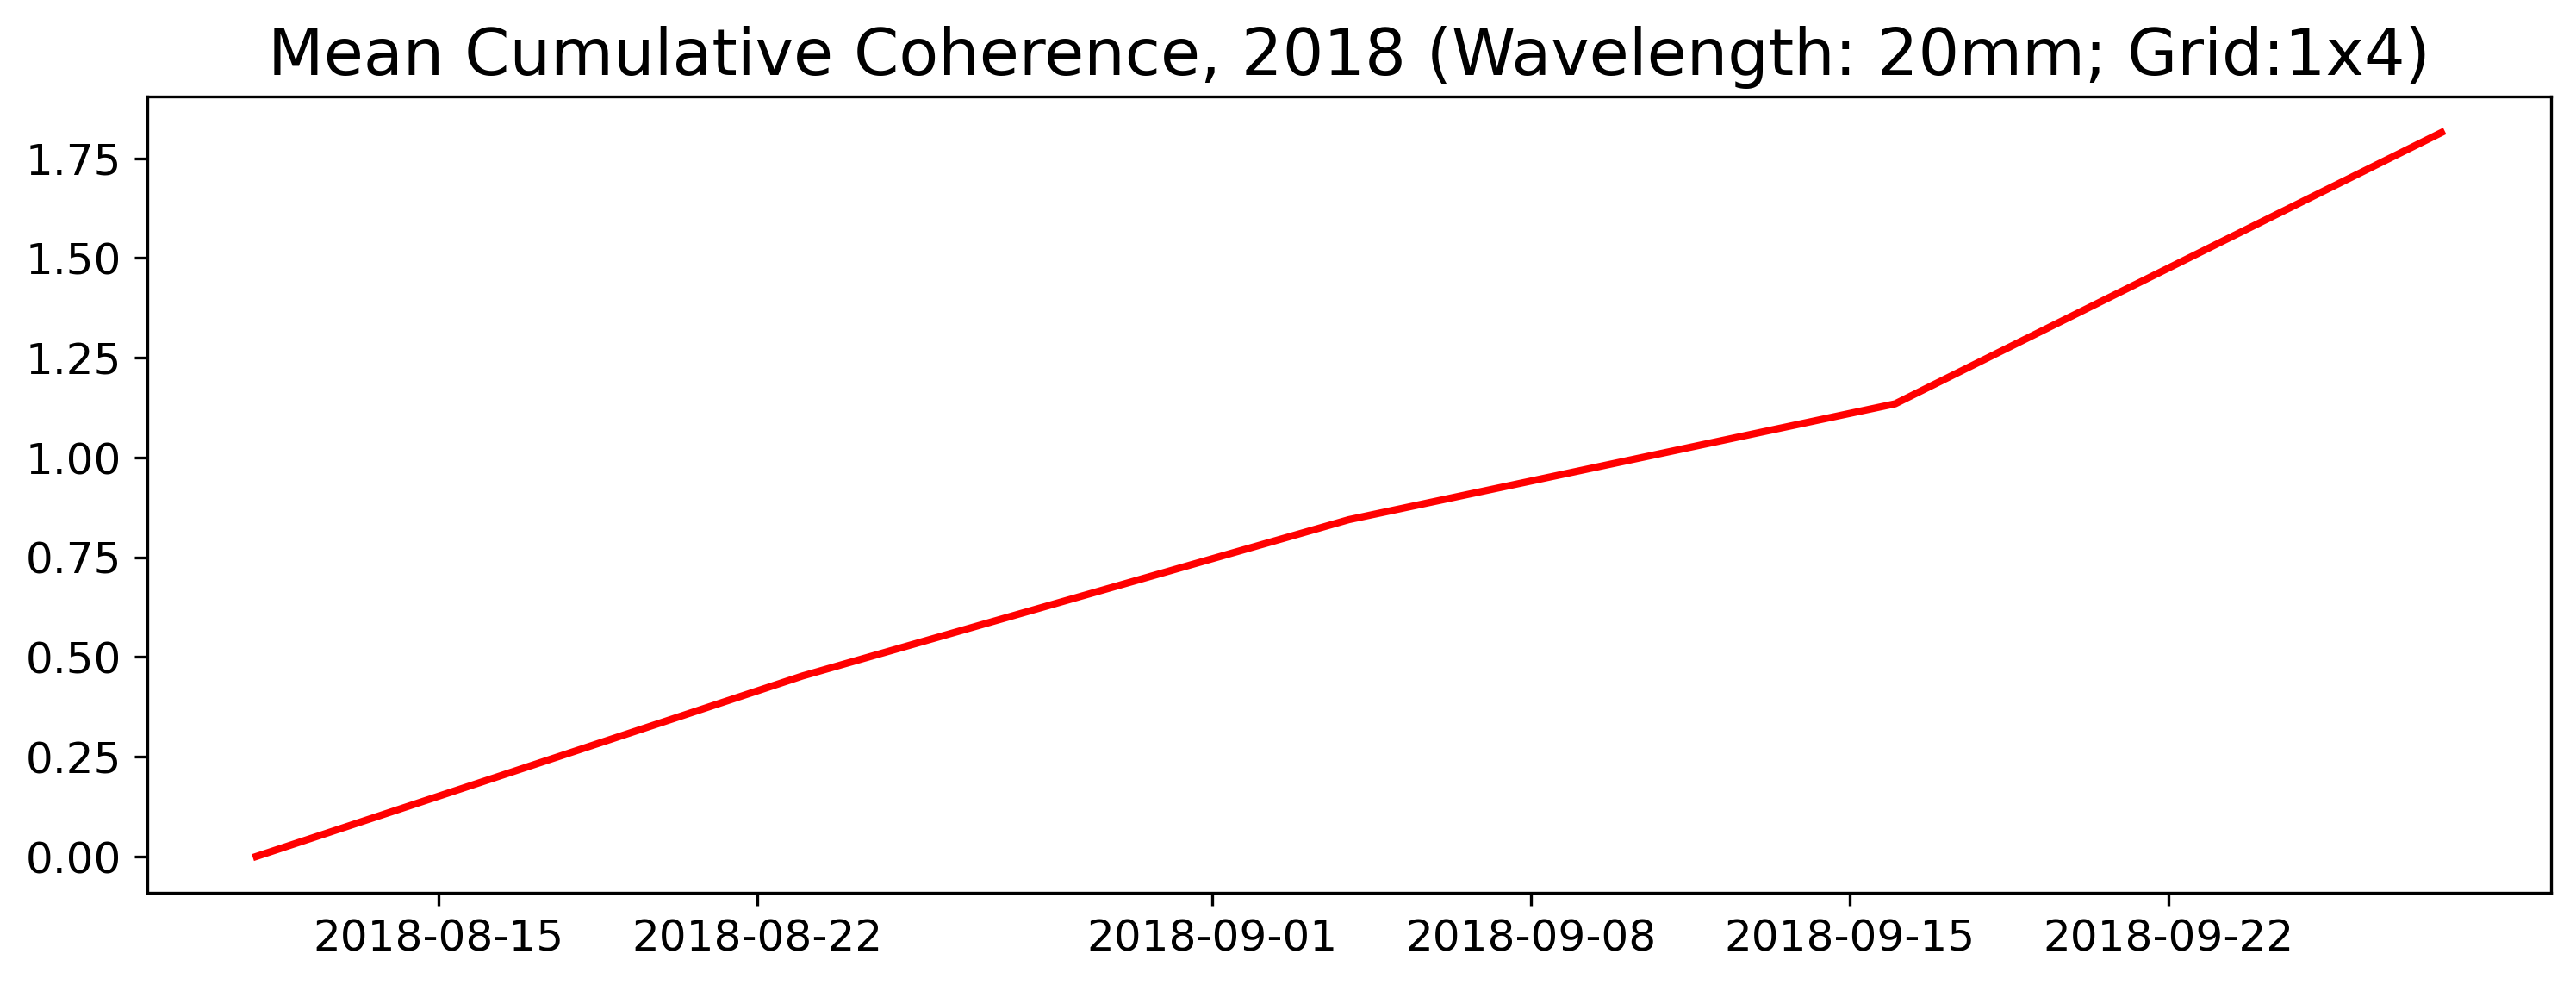

<Figure size 1200x400 with 0 Axes>

In [189]:
title = f'Mean Cumulative Coherence, {DATE} (Wavelength: 20mm; Grid:1x4)'
plt.figure(figsize=(12, 4), dpi=300)

plt.plot(corr_sbas_lstsq_mean.date, corr_sbas_lstsq_mean, c='r', lw=2, label='Coherence Least Squares')
plt.title(title, fontsize=18)
plt.show()
plt.savefig(title + '.jpg')

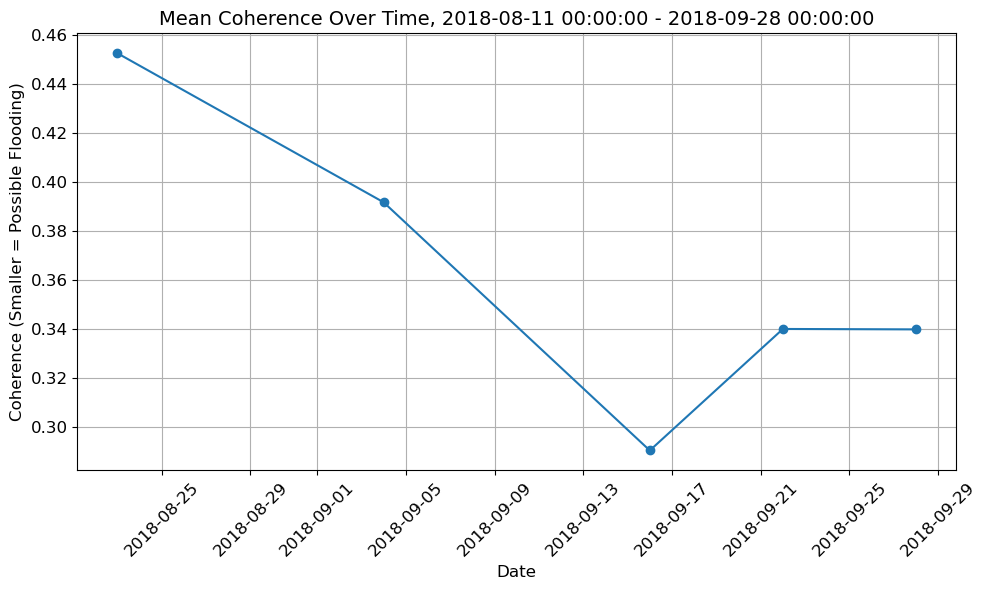

<Figure size 1200x400 with 0 Axes>

In [190]:
df = corr_sbas_lstsq_mean.to_dataframe()
df = df.reset_index()
title = 'Mean Coherence Over Time, {}'.format(str(df.iloc[0]['date']) + ' - ' + str(df.iloc[-1]['date']))
df = df.sort_values(by='date')

# Calculate the difference in cumulative correlation
df['correlation_diff'] = df['displacement'].diff()
df['correlation_diff'] = df['correlation_diff'].fillna(0)
df = df.iloc[1:].reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['correlation_diff'], marker='o', linestyle='-')
plt.title(title)
plt.xlabel('Date')
plt.ylabel('Coherence (Smaller = Possible Flooding)')
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig(title + '.jpg')

In [191]:
corr_sbas_lstsq_stl = sbas.sync_cube(corr_sbas_lstsq_stl, 'corr_sbas_lstsq_stl')
corr_sbas_lstsq_stl_trend_mean = corr_sbas_lstsq_stl.trend.mean(['y', 'x'])
corr_sbas_lstsq_stl_seasonal_mean = corr_sbas_lstsq_stl.seasonal.mean(['y', 'x'])

Syncing NetCDF 2D/3D Dataset:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

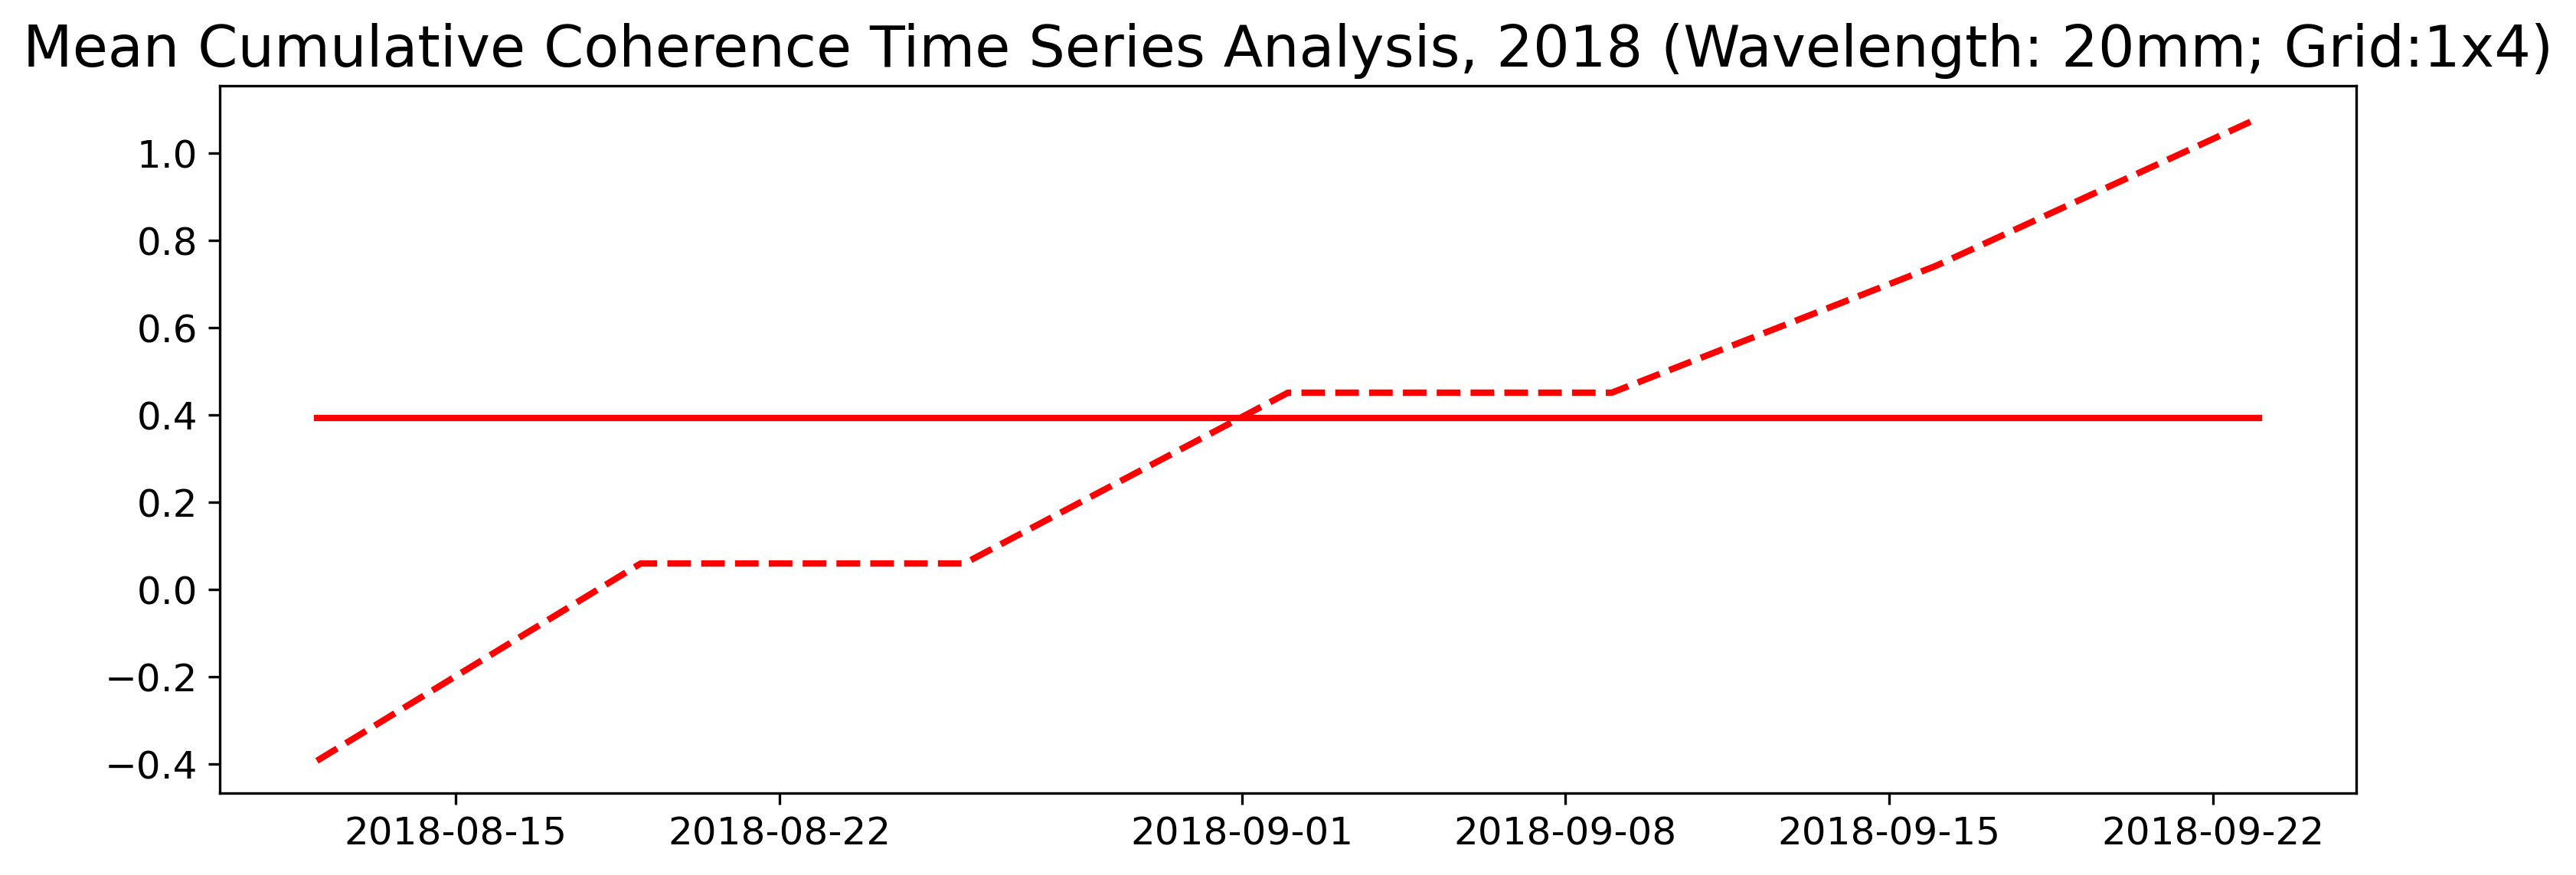

<Figure size 1200x400 with 0 Axes>

In [192]:
title = f'Mean Cumulative Coherence Time Series Analysis, {DATE} (Wavelength: 20mm; Grid:1x4)'
plt.figure(figsize=(12, 4), dpi=300)

plt.plot(corr_sbas_lstsq_stl_trend_mean.date, corr_sbas_lstsq_stl_trend_mean, c='r', lw=2, label='Coherence Least Squares')
plt.plot(corr_sbas_lstsq_stl_seasonal_mean.date, corr_sbas_lstsq_stl_seasonal_mean, c='r', lw=2, ls='--', label='Coherence Least Squares')
plt.title(title, fontsize=18)
plt.show()
plt.savefig(title + '.jpg')

In [193]:
corr_sbas_mean = corr_sbas.mean(['y', 'x'])
corr_sbas_max = corr_sbas.max(['y', 'x'])

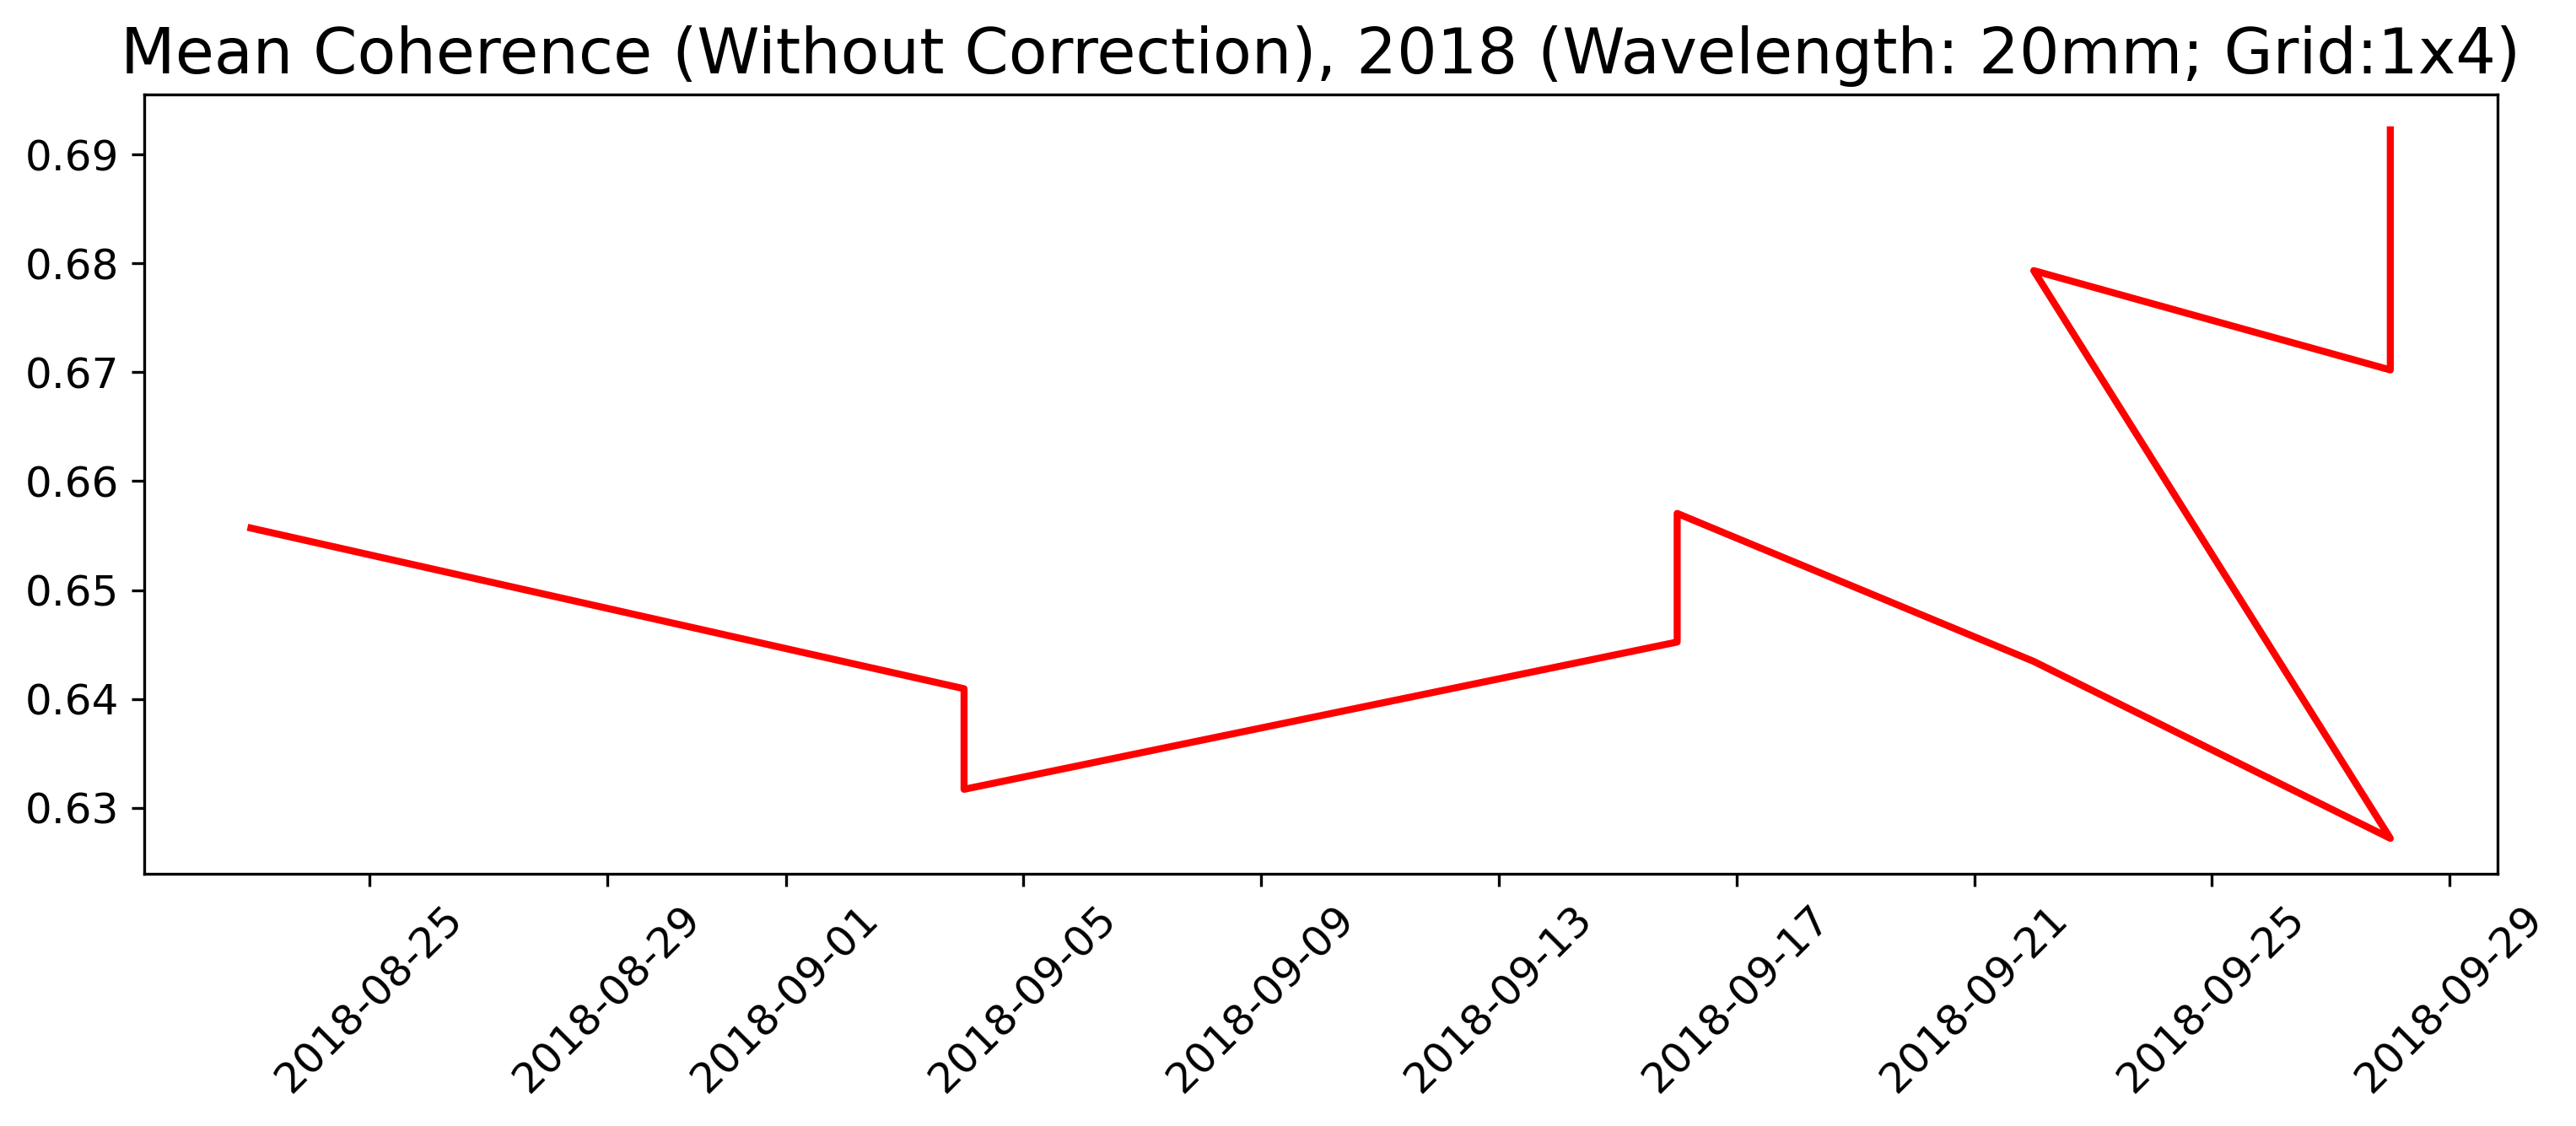

<Figure size 1200x400 with 0 Axes>

In [194]:
title = f'Mean Coherence (Without Correction), {DATE} (Wavelength: 20mm; Grid:1x4)'
plt.figure(figsize=(12, 4), dpi=300)

plt.plot(corr_sbas_mean.rep, corr_sbas_mean, c='r', lw=2, label='Coherence Least Squares')
plt.title(title, fontsize=18)
plt.xticks(rotation=45)
plt.show()
plt.savefig(title + '.jpg')

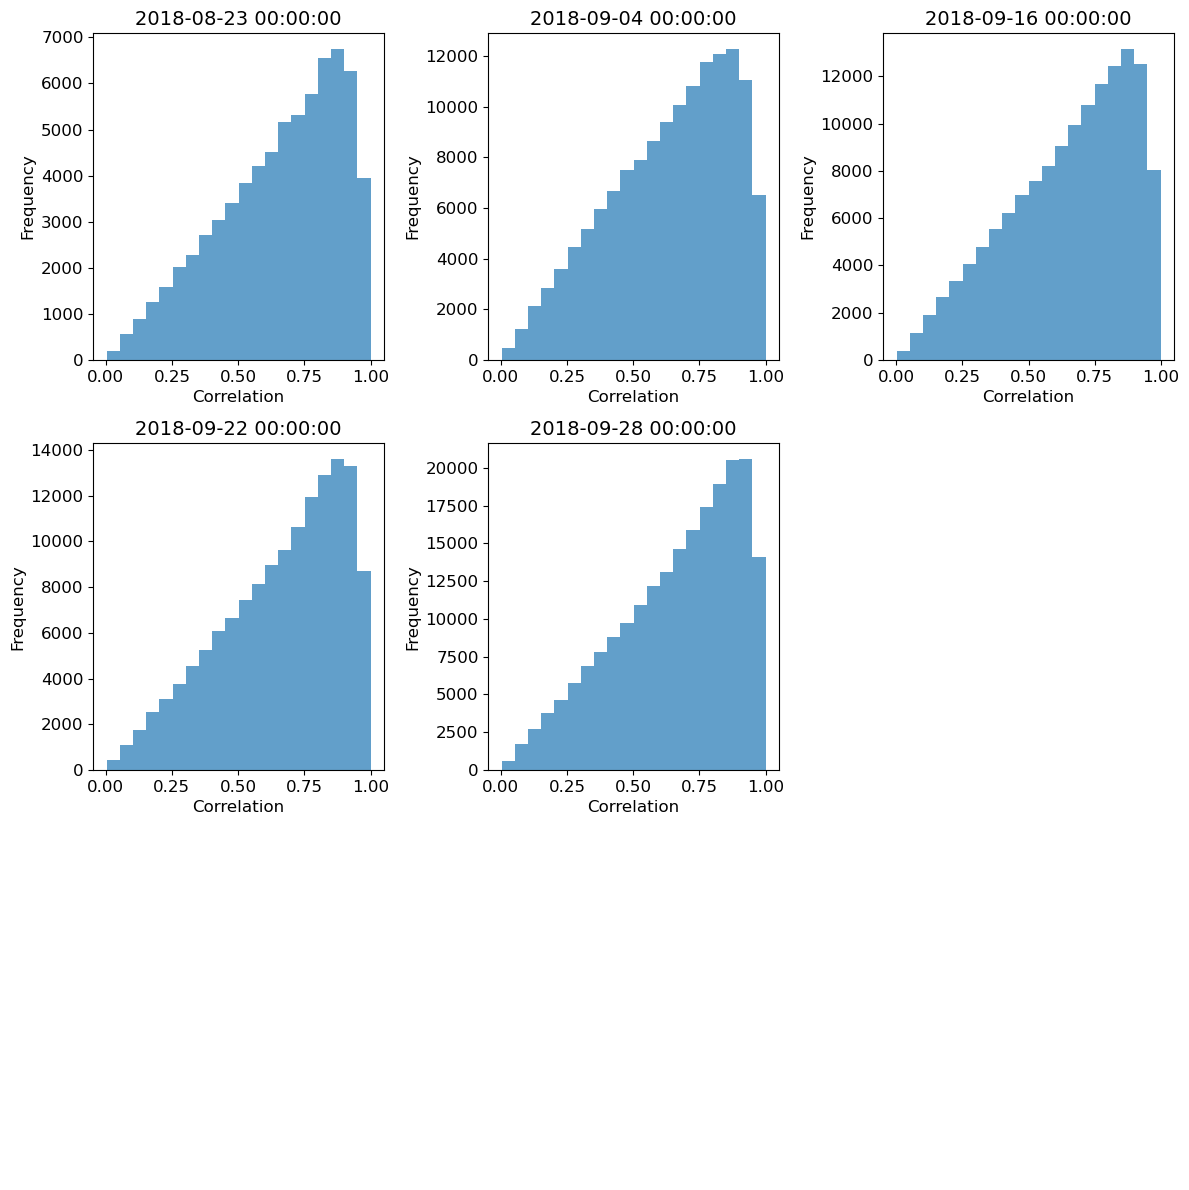

In [195]:
import math
df = corr_sbas.to_dataframe()
# Assuming 'df' is your multi-index DataFrame and 'rep' is one of the index levels
# Reset index if necessary to make 'rep' a column
df = df.reset_index()

# Get unique 'rep' values
unique_reps = df['rep'].unique()
num_reps = len(unique_reps)

# Determine grid size for the collage (e.g., a square grid for simplicity)
grid_size = math.ceil(math.sqrt(num_reps))

# Create figure with subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
axes = axes.flatten()  # Flatten axes array to easily itsbas.compute_reframe(AOI)erate over it

# Loop through each 'rep' value and plot its histogram
for i, rep in enumerate(unique_reps):
    group_data = df[df['rep'] == rep]
    axes[i].hist(group_data['correlation'], bins=20, alpha=0.7)
    axes[i].set_title(rep)
    axes[i].set_xlabel('Correlation')
    axes[i].set_ylabel('Frequency')# corr_sbas_lstsq_stl = 

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [196]:
PRE_FLOOD_DOI = '2018-08-23 2018-09-04'
CO_FLOOD_DOI = '2018-09-04 2018-09-16'
corr_sbas_df = corr_sbas.to_dataframe()
pre_flood_df = corr_sbas_df[corr_sbas_df.index.get_level_values(0) == PRE_FLOOD_DOI]
co_flood_df = corr_sbas_df[corr_sbas_df.index.get_level_values(0) == CO_FLOOD_DOI]
pre_flood_df.to_csv(f'csv/{PRE_FLOOD_DOI} {POLARIZATION}.csv')
co_flood_df.to_csv(f'csv/{CO_FLOOD_DOI} {POLARIZATION}.csv')

# Conclusion